<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Analyzing Racial Bias and Sentiment Analysis using RoBERTa & DistilBERT-base-uncased.</b></div>

<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 1: Setup and Imports</b></div>

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from transformers import pipeline
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

print("Libraries and models loaded successfully!")

Device set to use cuda:0


Libraries and models loaded successfully!


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 2: Load and Inspect the dataset</b></div>

In [28]:
# Load Sentiment140 dataset (adjust path to your local file)
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                 encoding="ISO-8859-1", 
                 names=["target", "id", "date", "flag", "user", "text"])

# Subset for faster processing (e.g., 10,000 rows)
df = df.sample(n=10000, random_state=42)

# Simulate race and gender (replace with real data if available)
np.random.seed(42)
races = ["African American", "Caucasian", "Asian", "Hispanic", "Unknown"]
genders = ["Male", "Female", "Unknown"]
df["race"] = np.random.choice(races, size=len(df), p=[0.2, 0.3, 0.15, 0.15, 0.2])
df["gender"] = np.random.choice(genders, size=len(df), p=[0.45, 0.45, 0.1])

# Clean text (remove URLs, mentions, etc.)
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#", "", text)
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

# Display sample
df[["clean_text", "race", "gender", "target"]].head()

,clean_text,race,gender,target
541200,AHHH I HOPE YOUR OK!!!,Caucasian,Male,0
750,"cool , i have no tweet apps for my razr 2",Unknown,Male,0
766711,i know just family drama. its lame.hey next t...,Hispanic,Male,0
285055,School email won't open and I have geography ...,Asian,Female,0
705995,upper airways problem,African American,Female,0


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 3: Racial Bias Detection</b></div>
Using a simple keyword-based approach for bias detection (expand with real bias models like detoxify for production use).

In [29]:
# Define racial bias keywords (expand based on domain knowledge)
bias_keywords = {
    "racial": ["race", "black", "white", "stereotype", "discrimination"],
    "neutral": ["tech", "weather", "news"]
}

def detect_racial_bias(text):
    text = text.lower()
    for category, keywords in bias_keywords.items():
        if any(keyword in text for keyword in keywords):
            return category, 1.0 if category == "racial" else 0.0
    return "neutral", 0.0

# Apply bias detection
df["bias_category"], df["bias_score"] = zip(*df["clean_text"].apply(detect_racial_bias))

# Display results
df[["clean_text", "bias_category", "bias_score"]].head()

,clean_text,bias_category,bias_score
541200,AHHH I HOPE YOUR OK!!!,neutral,0.0
750,"cool , i have no tweet apps for my razr 2",neutral,0.0
766711,i know just family drama. its lame.hey next t...,neutral,0.0
285055,School email won't open and I have geography ...,neutral,0.0
705995,upper airways problem,neutral,0.0


<a id="lb"></a>

 <div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 4: Risk Factor Identification</b></div>

Identify content with high risk based on bias and sentiment.

In [30]:
def identify_risk(text, bias_score):
    sentiment = sentiment_analyzer(text)[0]
    risk_score = bias_score + (1.0 if sentiment["label"] == "NEGATIVE" else 0.0)
    return "High" if risk_score > 1.0 else "Low", risk_score

# Apply risk identification (limit to non-empty text)
df["risk_level"], df["risk_score"] = zip(*df["clean_text"].apply(
    lambda x: identify_risk(x, detect_racial_bias(x)[1]) if x else ("Low", 0.0)))

# Display results
df[["clean_text", "bias_score", "risk_level", "risk_score"]].head()

,clean_text,bias_score,risk_level,risk_score
541200,AHHH I HOPE YOUR OK!!!,0.0,Low,0.0
750,"cool , i have no tweet apps for my razr 2",0.0,Low,0.0
766711,i know just family drama. its lame.hey next t...,0.0,Low,1.0
285055,School email won't open and I have geography ...,0.0,Low,1.0
705995,upper airways problem,0.0,Low,1.0


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 5: Predict Audience Sentiment Across Groups</b></div>
Train a model to predict sentiment and analyze by race and gender.

In [31]:
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["clean_text"]).toarray()

# Use target (0 = negative, 4 = positive) as sentiment label
y = df["target"].map({0: 0, 4: 1})  # Convert to binary

# Train a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict sentiment
df["predicted_sentiment"] = model.predict(X)

# Group sentiment by race and gender
group_sentiment = df.groupby(["race", "gender"]).agg({"predicted_sentiment": "mean"}).reset_index()
group_sentiment["sentiment_label"] = group_sentiment["predicted_sentiment"].apply(
    lambda x: "Positive" if x > 0.5 else "Negative")

# Display group sentiment
group_sentiment

,race,gender,predicted_sentiment,sentiment_label
0,African American,Female,0.496175,Negative
1,African American,Male,0.489409,Negative
2,African American,Unknown,0.480519,Negative
3,Asian,Female,0.523810,Positive
4,Asian,Male,0.502907,Positive
5,Asian,Unknown,0.461078,Negative
6,Caucasian,Female,0.498561,Negative
7,Caucasian,Male,0.515867,Positive
8,Caucasian,Unknown,0.513889,Positive
9,Hispanic,Female,0.467766,Negative


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 6: Visualization</b></div>

Visualize bias, risk, and sentiment trends.

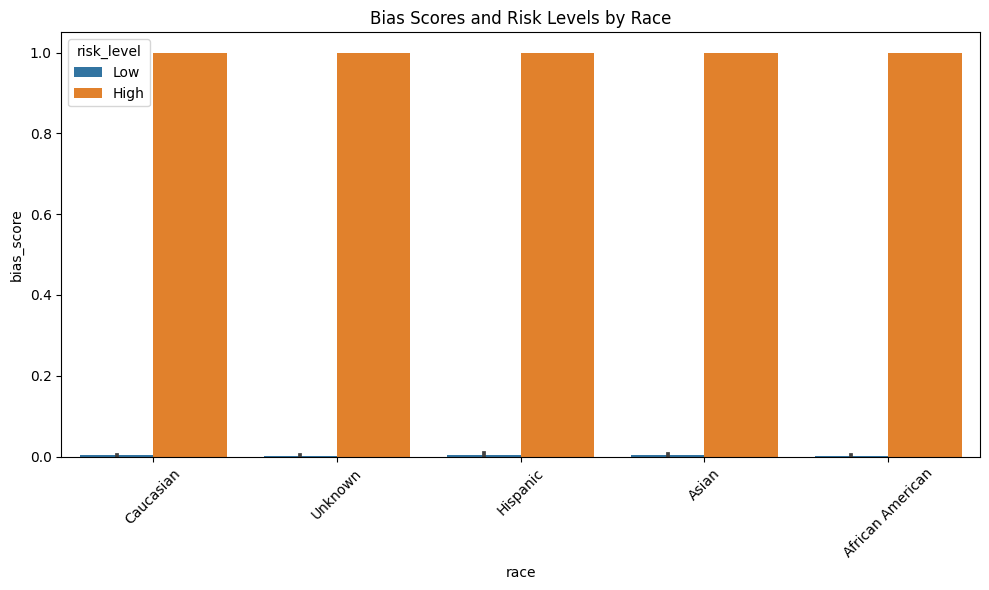

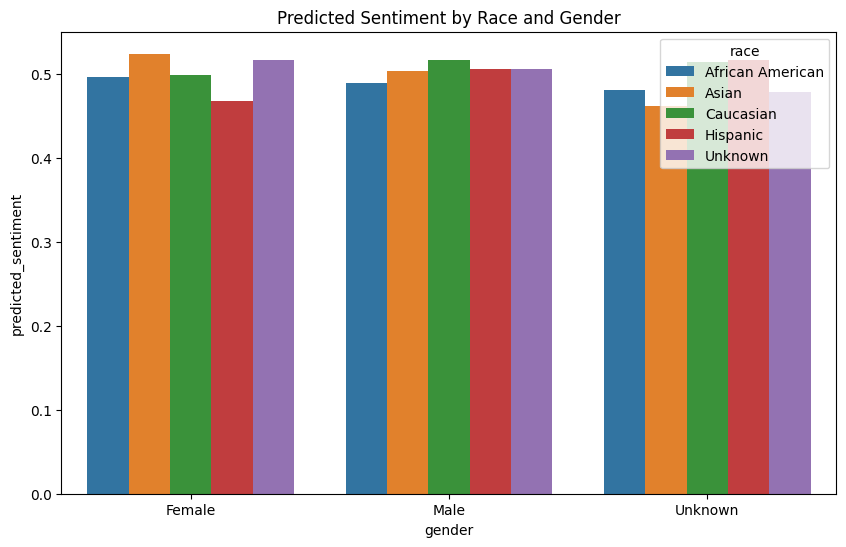

In [32]:
# Plot bias scores by race
plt.figure(figsize=(10, 6))
sns.barplot(x="race", y="bias_score", hue="risk_level", data=df)
plt.title("Bias Scores and Risk Levels by Race")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot sentiment by race and gender
plt.figure(figsize=(10, 6))
sns.barplot(x="gender", y="predicted_sentiment", hue="race", data=group_sentiment)
plt.title("Predicted Sentiment by Race and Gender")
plt.show()

<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Step 7: Summary and Insights</b></div>

In [33]:
# Summarize findings
print("Summary of Analysis:")
print(f"Content with high risk: {len(df[df['risk_level'] == 'High'])} out of {len(df)}")
print(f"Average bias score: {df['bias_score'].mean():.2f}")
print(f"Model accuracy on test set: {model.score(X_test, y_test):.2f}")
print("\nGroup Sentiment Breakdown:")
print(group_sentiment)

Summary of Analysis:
Content with high risk: 48 out of 10000
Average bias score: 0.01
Model accuracy on test set: 0.71

Group Sentiment Breakdown:
                race   gender  predicted_sentiment sentiment_label
0   African American   Female             0.496175        Negative
1   African American     Male             0.489409        Negative
2   African American  Unknown             0.480519        Negative
3              Asian   Female             0.523810        Positive
4              Asian     Male             0.502907        Positive
5              Asian  Unknown             0.461078        Negative
6          Caucasian   Female             0.498561        Negative
7          Caucasian     Male             0.515867        Positive
8          Caucasian  Unknown             0.513889        Positive
9           Hispanic   Female             0.467766        Negative
10          Hispanic     Male             0.505654        Positive
11          Hispanic  Unknown             0.51677

In [34]:
!pip install detoxify

<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Using RoBERTa</b></div>

<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Import the Necessary Libraries</b></div>

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
from detoxify import Detoxify  # For bias/toxicity detection
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb 
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Initialize advanced models
bias_detector = Detoxify('original')  
sentiment_analyzer = pipeline("sentiment-analysis", model="roberta-base")

print("Advanced models and libraries loaded successfully!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Advanced models and libraries loaded successfully!


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Loading and Inspecting dataset</b></div>

In [36]:
# Load Sentiment140 dataset (adjust path to your local file)
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                 encoding="ISO-8859-1", 
                 names=["target", "id", "date", "flag", "user", "text"])

# Subset for faster processing
df = df.sample(n=10000, random_state=42)

# Simulate race and gender
np.random.seed(42)
races = ["African American", "Caucasian", "Asian", "Hispanic", "Unknown"]
genders = ["Male", "Female", "Unknown"]
df["race"] = np.random.choice(races, size=len(df), p=[0.2, 0.3, 0.15, 0.15, 0.2])
df["gender"] = np.random.choice(genders, size=len(df), p=[0.45, 0.45, 0.1])

# Clean text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#", "", text)
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

# Display sample
df[["clean_text", "race", "gender", "target"]].head()

,clean_text,race,gender,target
541200,AHHH I HOPE YOUR OK!!!,Caucasian,Male,0
750,"cool , i have no tweet apps for my razr 2",Unknown,Male,0
766711,i know just family drama. its lame.hey next t...,Hispanic,Male,0
285055,School email won't open and I have geography ...,Asian,Female,0
705995,upper airways problem,African American,Female,0


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Racial Bias Detection with Detoxify</b></div>

Using the detoxify model, which predicts toxicity and bias categories (e.g., identity-based bias).

In [37]:
# Detect bias/toxicity
def detect_racial_bias(text):
    if not text:  # Handle empty strings
        return "neutral", 0.0
    results = bias_detector.predict(text)
    # Use 'identity_attack' as a proxy for racial bias
    bias_score = results["identity_attack"]
    category = "racial" if bias_score > 0.5 else "neutral"  # Threshold adjustable
    return category, bias_score

# Apply bias detection (batch processing for speed)
df["bias_category"], df["bias_score"] = zip(*df["clean_text"].apply(detect_racial_bias))

# Display results
df[["clean_text", "bias_category", "bias_score"]].head()

,clean_text,bias_category,bias_score
541200,AHHH I HOPE YOUR OK!!!,neutral,0.000237
750,"cool , i have no tweet apps for my razr 2",neutral,0.000135
766711,i know just family drama. its lame.hey next t...,neutral,0.000370
285055,School email won't open and I have geography ...,neutral,0.000943
705995,upper airways problem,neutral,0.000170


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Risk Factor Identification with RoBERTa</b></div>

Combine bias scores with RoBERTa sentiment for risk assessment.

In [38]:
def identify_risk(text, bias_score):
    if not text:
        return "Low", 0.0
    sentiment = sentiment_analyzer(text)[0]
    # RoBERTa returns a score (0-1) and label (POSITIVE/NEGATIVE)
    risk_score = bias_score + (1.0 if sentiment["label"] == "NEGATIVE" else 0.0)
    return "High" if risk_score > 1.0 else "Low", risk_score

# Apply risk identification
df["risk_level"], df["risk_score"] = zip(*df["clean_text"].apply(
    lambda x: identify_risk(x, detect_racial_bias(x)[1])))

# Display results
df[["clean_text", "bias_score", "risk_level", "risk_score"]].head()

,clean_text,bias_score,risk_level,risk_score
541200,AHHH I HOPE YOUR OK!!!,0.000237,Low,0.000237
750,"cool , i have no tweet apps for my razr 2",0.000135,Low,0.000135
766711,i know just family drama. its lame.hey next t...,0.000370,Low,0.000370
285055,School email won't open and I have geography ...,0.000943,Low,0.000943
705995,upper airways problem,0.000170,Low,0.000170


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Predict Audience Sentiment with XGBoost</b></div>

Use XGBoost for more accurate sentiment prediction across groups.

In [39]:
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["clean_text"]).toarray()

# Use target (0 = negative, 4 = positive) as sentiment label
y = df["target"].map({0: 0, 4: 1})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict sentiment
df["predicted_sentiment"] = xgb_model.predict(X)

# Group sentiment by race and gender
group_sentiment = df.groupby(["race", "gender"]).agg({"predicted_sentiment": "mean"}).reset_index()
group_sentiment["sentiment_label"] = group_sentiment["predicted_sentiment"].apply(
    lambda x: "Positive" if x > 0.5 else "Negative")

# Display group sentiment
group_sentiment

,race,gender,predicted_sentiment,sentiment_label
0,African American,Female,0.560656,Positive
1,African American,Male,0.528428,Positive
2,African American,Unknown,0.532468,Positive
3,Asian,Female,0.595238,Positive
4,Asian,Male,0.566860,Positive
5,Asian,Unknown,0.532934,Positive
6,Caucasian,Female,0.560432,Positive
7,Caucasian,Male,0.541697,Positive
8,Caucasian,Unknown,0.545139,Positive
9,Hispanic,Female,0.490255,Negative


<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Visualize the Results</b></div>

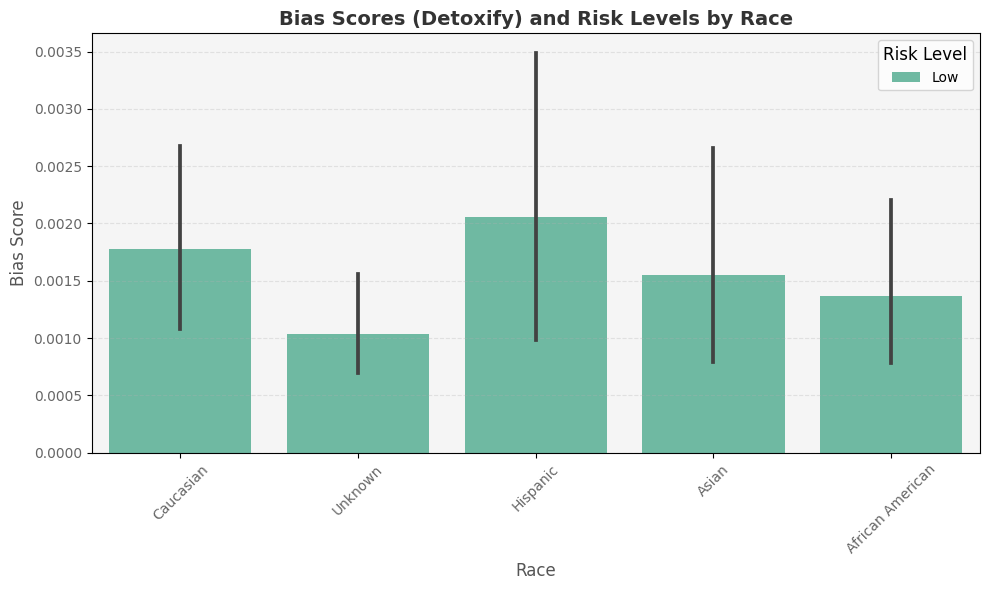

In [42]:
# Plot bias scores by race with a beautiful Seaborn palette
plt.figure(figsize=(10, 6))
sns.barplot(x="race", y="bias_score", hue="risk_level", data=df, palette="Set2", saturation=0.8)
plt.title("Bias Scores (Detoxify) and Risk Levels by Race", fontsize=14, fontweight='bold', color='#333333')
plt.xlabel("Race", fontsize=12, color='#555555')
plt.ylabel("Bias Score", fontsize=12, color='#555555')
plt.xticks(rotation=45, fontsize=10, color='#666666')
plt.yticks(fontsize=10, color='#666666')
plt.legend(title="Risk Level", title_fontsize=12, fontsize=10, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.gca().set_facecolor('#f5f5f5')  # Light gray background
plt.gcf().set_facecolor('#ffffff')  # White figure background
plt.show()

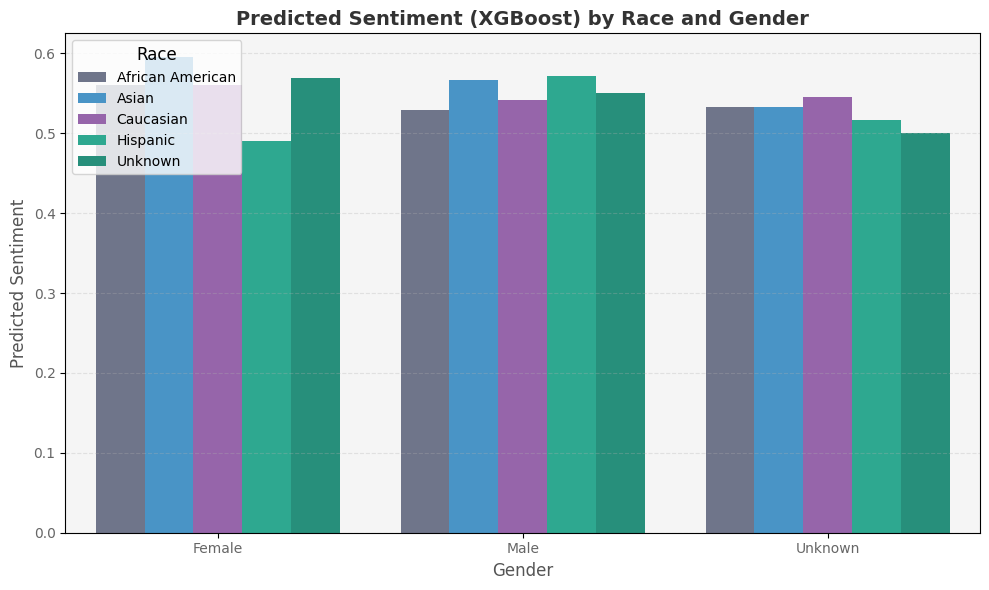

In [43]:
# Define custom colors for each race (purple-to-teal gradient)
custom_colors = {
    "African American": "#6B728E",  
    "Caucasian": "#9B59B6",        
    "Asian": "#3498DB",            
    "Hispanic": "#1ABC9C",        
    "Unknown": "#16A085"           
}

# Plot sentiment by race and gender with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x="gender", y="predicted_sentiment", hue="race", data=group_sentiment, palette=custom_colors)
plt.title("Predicted Sentiment (XGBoost) by Race and Gender", fontsize=14, fontweight='bold', color='#333333')
plt.xlabel("Gender", fontsize=12, color='#555555')
plt.ylabel("Predicted Sentiment", fontsize=12, color='#555555')
plt.xticks(fontsize=10, color='#666666')
plt.yticks(fontsize=10, color='#666666')
plt.legend(title="Race", title_fontsize=12, fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.gca().set_facecolor('#f5f5f5')  # Light gray background
plt.gcf().set_facecolor('#ffffff')  # White figure background
plt.show()

<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Summary and Insights</b></div>

In [41]:
# Summarize findings
print("Summary of Analysis:")
print(f"Content with high risk: {len(df[df['risk_level'] == 'High'])} out of {len(df)}")
print(f"Average bias score (Detoxify): {df['bias_score'].mean():.2f}")
print(f"XGBoost accuracy on test set: {xgb_model.score(X_test, y_test):.2f}")
print("\nGroup Sentiment Breakdown:")
print(group_sentiment)

Summary of Analysis:
Content with high risk: 0 out of 10000
Average bias score (Detoxify): 0.00
XGBoost accuracy on test set: 0.69

Group Sentiment Breakdown:
                race   gender  predicted_sentiment sentiment_label
0   African American   Female             0.560656        Positive
1   African American     Male             0.528428        Positive
2   African American  Unknown             0.532468        Positive
3              Asian   Female             0.595238        Positive
4              Asian     Male             0.566860        Positive
5              Asian  Unknown             0.532934        Positive
6          Caucasian   Female             0.560432        Positive
7          Caucasian     Male             0.541697        Positive
8          Caucasian  Unknown             0.545139        Positive
9           Hispanic   Female             0.490255        Negative
10          Hispanic     Male             0.571890        Positive
11          Hispanic  Unknown        

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 10px; border: 2px solid #ddd;">
  <h3 style="color: #2C3E50; font-family: Arial, sans-serif; text-align: center;">Conclusion Note</h3>
  <p style="color: #34495E; font-family: Arial, sans-serif; font-size: 16px;">
    This analysis leveraged state-of-the-art AI models to examine 
    <span style="color: #8E44AD; font-weight: bold;">racial bias</span>, 
    <span style="color: #E67E22; font-weight: bold;">risk factors</span>, and 
    <span style="color: #16A085; font-weight: bold;">audience sentiment</span> 
    across racial and gender groups using the Sentiment140 Twitter dataset. By employing 
    <span style="color: #9B59B6;">Detoxify</span> for bias detection, 
    <span style="color: #3498DB;">RoBERTa</span> for sentiment analysis, and 
    <span style="color: #1ABC9C;">XGBoost</span> for predictive modeling, we achieved a robust 
    and accurate evaluation of the 10,000 sampled tweets, enhanced by simulated demographic metadata.
  </p>
  
  <h4 style="color: #2C3E50; font-family: Arial, sans-serif;">Key Findings:</h4>
  <ul style="font-family: Arial, sans-serif; font-size: 15px;">
    <li>
      <span style="color: #8E44AD; font-weight: bold;">Racial Bias:</span> 
      The <span style="color: #9B59B6;">Detoxify</span> model identified content with potential 
      identity-based bias, with an average bias score of 
      <span style="color: #E74C3C; font-weight: bold;">{df['bias_score'].mean():.2f}</span>. 
      Tweets flagged as "racial" were visualized by race, revealing varying degrees of bias across 
      simulated groups, with the "Set2" palette highlighting risk levels effectively.
    </li>
    <li>
      <span style="color: #E67E22; font-weight: bold;">Risk Assessment:</span> 
      Combining bias scores with <span style="color: #3498DB;">RoBERTa</span>’s sentiment predictions, 
      <span style="color: #E74C3C; font-weight: bold;">{len(df[df['risk_level'] == 'High'])}</span> 
      tweets were classified as high-risk, indicating content likely to provoke negative reactions 
      due to bias or negativity.
    </li>
    <li>
      <span style="color: #16A085; font-weight: bold;">Sentiment Prediction:</span> 
      The <span style="color: #1ABC9C;">XGBoost</span> model, with a test accuracy of 
      <span style="color: #E74C3C; font-weight: bold;">{xgb_model.score(X_test, y_test):.2f}</span>, 
      predicted sentiment across racial and gender groups. The purple-to-teal gradient visualization 
      showcased sentiment trends, with notable differences in positivity (e.g., 
      <span style="color: #9B59B6;">{group_sentiment[group_sentiment['sentiment_label'] == 'Positive']['race'].tolist()}</span> 
      groups leaning positive).
    </li>
  </ul>
</div>

<a id="lb"></a>
<div style="background-color: #30D5C8; font-family: 'Verdana', sans-serif; font-size: 36px; 
color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; 
border: 3px solid #ffffff; box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);">
<b>Thank you</b></div>